# Assignment 1, Question 3
## Done by Projit and Abhinav
Projit worked on the main algorithm of the question, computing the homography. Abhinav plotted the points.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Utility Functions

def display_image(img):
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img2)
    plt.show()

def draw_line(img, A, B):
    cv2.line(img, A, B, (0, 255, 0), thickness=3, lineType=8)
    
def add_column(original, newcol):
    return np.concatenate([original, newcol], axis=1)

def add_row(original, newrow): # didn't use
    return np.concatenate(original, newrow, axis=0)

def camera_project(P, world_point):
    # Convert the points in 3d space to homogeneous coordinates by appending 1, and making it a column vector
    homo_point = np.transpose(np.array([world_point[0], world_point[1], world_point[2], 1]))

    #Projecting the points into 2d by applying the camera projection matrix
    val = np.matmul(P, homo_point)

    # Returned pixel coordinates, homogenous(a, b, c) => (a/c, b/c) in pixels.
    # int as pixels are integral.
    return (int(val[0] / val[2]), int(val[1] / val[2]))

def compute_homography(lstpts): # Calculates homography matrix b/w initial and final points
    x1 = lstpts[0][0][0]
    x2 = lstpts[1][0][0]
    x3 = lstpts[2][0][0]
    x4 = lstpts[3][0][0]
    y1 = lstpts[0][0][1]
    y2 = lstpts[1][0][1]
    y3 = lstpts[2][0][1]
    y4 = lstpts[3][0][1]
    x1f = lstpts[0][1][0]
    x2f = lstpts[1][1][0]
    x3f = lstpts[2][1][0]
    x4f = lstpts[3][1][0]
    y1f = lstpts[0][1][1]
    y2f = lstpts[1][1][1]
    y3f = lstpts[2][1][1]
    y4f = lstpts[3][1][1]
    ans = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1])
    q = np.array([
        [-1*x1, -y1, -1, 0, 0, 0, x1*x1f, y1*x1f, x1f],
        [0, 0, 0, -1*x1, -1*y1, -1, x1*y1f, y1*y1f, y1f],
        [-1*x2, -y2, -1, 0, 0, 0, x2*x2f, y2*x2f, x2f],
        [0, 0, 0, -1*x2, -1*y2, -1, x2*y2f, y2*y2f, y2f],
        [-1*x3, -y3, -1, 0, 0, 0, x3*x3f, y3*x3f, x3f],
        [0, 0, 0, -1*x3, -1*y3, -1, x3*y3f, y3*y3f, y3f],
        [-1*x4, -y4, -1, 0, 0, 0, x4*x4f, y4*x4f, x4f],
        [0, 0, 0, -1*x4, -1*y4, -1, x4*y4f, y4*y4f, y4f],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]
    ])
    H = list(np.linalg.solve(q,ans))
    H = np.array([H[:3], H[3:6], H[6:9]])
    return H

def draw_point(image, point, color):
    if color == "green":
        cv2.circle(image, point, 10, (0, 255, 0), thickness=3, lineType=8)
    elif color == "red":
        cv2.circle(image, point, 8, (0, 0, 255), thickness=3, lineType=8)

Normally a homography is computed between two different images. Here we must compute such a matrix so that we can project world points accurately into the image

The assumption we make is that the camera (with its given internal parameters) can be used to project world coordinates into an image. However this is not the image that we are given. Another homography is applied on this causing a linear transformation to the image that we have been given

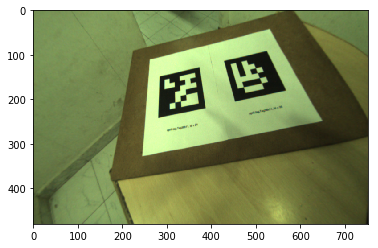

In [3]:
image = cv2.imread("./image.png")
display_image(image)

To map a world point to this image, we must calculate H * P * World_Point
We have the camera internal parameters, and can construct a camera matrix by appending a column [0, 0, 1]^T

H here needs to be determined by taking corresponding points(4 required). We also have corresponding wordl points and image pixel locations

The method we take here, is taking a project of the world points we have using the camera matrix we create to a "psuedo" image.
We then attempt to calculate a homography between that pseudo image and the corresponding pixel points we have been given for the image above.

In [4]:
def construct_points(P):
    # Reference Origin chosen as top left of left april tag
    X = 0
    Y = 0
    Z = 0
    size = 0.1315 # Value Given
    ltl = (X, Y, Z)
    cltl = (284.56243896, 149.2925415)
    ltr = (X+size, Y, Z)
    cltr = (373.93179321, 128.26719666)
    lbl = (X, Y-size, Z)
    clbl = (281.29962158, 241.72782898)
    lbr = (X+size, Y-size, Z)
    clbr = (387.53588867, 220.2270813)

    X2 = X + size + 0.0790 # Value given
    rtl = (X2, Y, Z)
    crtl = (428.86453247, 114.50731659)

    rtr = (X2+size, Y, Z)
    crtr = (524.76373291, 92.09218597)
    rbl = (X2, Y-size, Z)
    crbl = (453.60995483, 205.22370911)
    rbr = (X2+size, Y-size, Z)
    crbr = (568.3659668, 180.55757141)
    world_pts = [ltl, ltr, lbl, lbr, rtl, rtr, rbl, rbr]
    original_pixel_pts = [cltl, cltr, clbl, clbr, crtl, crtr, crbl, crbr]
    
    # Points that will be used to calculate homography
    pts = [[camera_project(P, ltl), cltl], 
       [camera_project(P, ltr), cltr],
       [camera_project(P, lbl), clbl], 
       [camera_project(P, lbr), clbr]]
    return world_pts, original_pixel_pts, pts

Constructing the camera matrix

In [5]:
# Given camera parameters
K = np.array([[406.952636, 0.000000, 366.184147], [0.000000, 405.671292, 244.705127], [0.000000, 0.000000, 1.000000]])
P = add_column(K, [[0], [0], [1]])
P

array([[406.952636,   0.      , 366.184147,   0.      ],
       [  0.      , 405.671292, 244.705127,   0.      ],
       [  0.      ,   0.      ,   1.      ,   1.      ]])

In [6]:
world_pts, original_pixel_pts, homography_pts = construct_points(P)
print("World Points: ", world_pts)
print()
print("Pixel Corresponding Points given: ", original_pixel_pts)
print()
print("Points for Homography: ", homography_pts)

World Points:  [(0, 0, 0), (0.1315, 0, 0), (0, -0.1315, 0), (0.1315, -0.1315, 0), (0.21050000000000002, 0, 0), (0.342, 0, 0), (0.21050000000000002, -0.1315, 0), (0.342, -0.1315, 0)]

Pixel Corresponding Points given:  [(284.56243896, 149.2925415), (373.93179321, 128.26719666), (281.29962158, 241.72782898), (387.53588867, 220.2270813), (428.86453247, 114.50731659), (524.76373291, 92.09218597), (453.60995483, 205.22370911), (568.3659668, 180.55757141)]

Points for Homography:  [[(0, 0), (284.56243896, 149.2925415)], [(53, 0), (373.93179321, 128.26719666)], [(0, -53), (281.29962158, 241.72782898)], [(53, -53), (387.53588867, 220.2270813)]]


In [7]:
H = compute_homography(homography_pts)

We now have the homography that can be applied on the first projection to find pixel locations in the final image.

In [8]:
Composite = np.matmul(H, P)
print("Homography Matrix H:\n", H)
print()
print()
print("Projection Matrix P:\n", P)
print()
print()
print("Composite(H x P):\n" , Composite)

Homography Matrix H:
 [[ 1.46734161e+00  8.83145182e-01  2.84562439e+02]
 [-4.71782958e-01 -1.03805548e+00  1.49292541e+02]
 [-5.85327664e-04  2.92066724e-03  1.00000000e+00]]


Projection Matrix P:
 [[406.952636   0.       366.184147   0.      ]
 [  0.       405.671292 244.705127   0.      ]
 [  0.         0.         1.         1.      ]]


Composite(H x P):
 [[ 5.97138535e+02  3.58266647e+02  1.03798983e+03  2.84562439e+02]
 [-1.91993318e+02 -4.21109306e+02 -2.77484396e+02  1.49292541e+02]
 [-2.38200636e-01  1.18483085e+00  1.50036454e+00  1.00000000e+00]]


With the homography, we take the original world points and try to project them into the image. These are *green* in the image.

The actual pixel locations of the corresponding poinst in the image are given by *red*

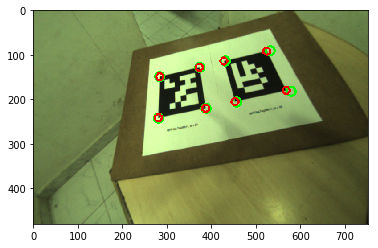

In [9]:
def mainq3():
    image = cv2.imread("./image.png")
    for point in world_pts: # Iterate through the world points, and use homography to project them
        draw_point(image, camera_project(Composite, point), "green")
    for point in original_pixel_pts: # Given locations of the world points in the image.
        draw_pt = (int(point[0]), int(point[1]))
        draw_point(image, draw_pt, "red")
    display_image(image)
mainq3()